In [24]:
import ast
import torch
import seaborn as sns
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

from torchmetrics.functional.classification import (
    f1_score,
    multilabel_precision,
    multilabel_recall,
    multilabel_average_precision,
    confusion_matrix,
)

from sklearn.metrics import accuracy_score

**Load annotations and results**

In [25]:
# Relevant paths
train_results_file = (
    "../dataset/results/model=slow_r50-w-negatives_e=100_split=train.pkl"
)
val_results_file = "../dataset/results/model=slow_r50-w-negatives_e=100_split=val.pkl"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segments.txt"

In [26]:
with open(
    train_results_file,
    "rb",
) as f:
    train_data = pkl.load(f)

with open(val_results_file, "rb") as f:
    val_data = pkl.load(f)

metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

In [27]:
def results2df(train_data, val_data, metadata_df):

    # Process subclips
    subclips = []
    for i, split in enumerate([train_data, val_data]):
        for name, pred, feat, label in zip(
            split["names"], split["preds"], split["feats"], split["labels"]
        ):
            subclips.append(
                {
                    "name": name,
                    "split": i,
                    "pred": pred,
                    "feat": feat,
                    "negative": True if sum(label) == 0 else False,
                }
            )

    df = pd.DataFrame(subclips, columns=["name", "split", "pred", "feat", "negative"])

    df["split"] = df.split.map({0: "train", 1: "val"})
    df = df.merge(metadata_df, how="left", left_on="name", right_on="subject_id")

    # Apply sigmoid to predictions
    df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))

    # Convert label from str to int
    df.label = df.label.apply(lambda x: np.array(ast.literal_eval(x)))

    # Add negative
    df["negative"] = df.label.apply(lambda x: sum(x) == 0)

    # Add global location count to dataframe
    df["location_count"] = df.utm.map(df.utm.value_counts())

    # Return train and val dataframes
    train_df = df[df.split == "train"]
    val_df = df[df.split == "val"]

    return train_df, val_df


def print_per_segement_performance(map, segment, show_per_class=False):
    res = []
    for i, (b, s) in enumerate(zip(map, segments)):
        if s == segment:
            res.append({behaviours[i]: b})
    agg_values = []
    for r in res:
        for _, value in r.items():
            agg_values.append(value)
    if show_per_class:
        print(f"{segment}: {np.mean(agg_values):.2f} {res}")
    else:
        print(f"{segment}: {np.mean(agg_values):.2f}")

In [28]:
# This will return dfs with preds, feats, labels, and all metadata
train_df, val_df = results2df(train_data, val_data, metadata_df)

**Split dfs by CT segements**

In [29]:
def return_ct_location_segments(df, head=50, tail=10):
    """
    Returns the location segments based on the given dataframe and thresholds.

    Args:
        df (pandas.DataFrame): The input dataframe containing the location data.
        head (int, optional): The threshold percentage for selecting locations that make up the top percentage of data. Defaults to 50.
        tail (int, optional): The threshold count for selecting locations outside the top percentage with more than this count. Defaults to 10.

    Returns:
        tuple: A tuple containing three dataframes:
            - head_locations: Dataframe containing the top locations and their video counts.
            - tail_locations: Dataframe containing the locations outside the top percentage with more than the tail count.
            - few_shot_locations: Dataframe containing the locations with fewer than the tail count.
    """
    # Group by 'utm' and count the number of videos for each location
    location_counts = train_df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Select locations that make up 50% of the data
    head_locations = location_counts[location_counts["cumulative_percentage"] <= head]

    # Calculate locations outside the top 50% with more than 10 samples
    tail_locations = location_counts[location_counts["cumulative_percentage"] > head]
    tail_locations = tail_locations[tail_locations["video_count"] > tail]

    # Calculate locations with fewer than 10 samples
    few_shot_locations = location_counts[location_counts["video_count"] < tail]

    return (
        head_locations[["utm", "video_count"]],
        tail_locations[["utm", "video_count"]],
        few_shot_locations[["utm", "video_count"]],
    )

**Plotting CT location distribution**

In [30]:
def plot_camera_locations_distribution(df, head=50, tail=10, use_proportion=False):
    # Group by 'utm' and count the number of videos for each location
    location_counts = df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative sum and percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Identify the indices for head (50%), tail (>10), and few-shot (<10) segments
    head_index = location_counts[
        location_counts["cumulative_percentage"] <= head
    ].index[-1]
    tail_index = location_counts[location_counts["video_count"] > tail].index[-1]

    # Determine y-axis values based on use_proportion
    y_values = (
        location_counts["cumulative_percentage"]
        if use_proportion
        else location_counts["cumulative_count"]
    )
    y_label = (
        "Cumulative Proportion of Videos"
        if use_proportion
        else "Cumulative Number of Videos"
    )
    y_max = 100 if use_proportion else total_videos

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(location_counts)), y_values, "b-")

    # Add vertical lines and annotations for segments
    plt.axvline(x=head_index, color="r", linestyle="--", label="Head (50%)")
    plt.axvline(x=tail_index, color="g", linestyle="--", label="Tail (>10 samples)")

    # Fill areas for each segment
    plt.fill_between(
        range(head_index + 1),
        y_values[: head_index + 1],
        alpha=0.3,
        color="r",
        label="Head",
    )
    plt.fill_between(
        range(head_index + 1, tail_index + 1),
        y_values[head_index + 1 : tail_index + 1],
        alpha=0.3,
        color="g",
        label="Tail",
    )
    plt.fill_between(
        range(tail_index + 1, len(location_counts)),
        y_values[tail_index + 1 :],
        alpha=0.3,
        color="y",
        label="Few-shot",
    )

    # Customize the plot
    plt.title("Cumulative Distribution of Videos Across Camera Locations")
    plt.xlabel("Camera Locations (sorted by video count)")
    plt.ylabel(y_label)
    plt.legend()

    # Add text annotations
    plt.text(
        head_index,
        y_max / 2,
        f"Head: {head_index+1} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        tail_index,
        y_max / 2,
        f"Tail: {tail_index-head_index} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        len(location_counts) - 1,
        y_max / 2,
        f"Few-shot: {len(location_counts)-tail_index-1} locations",
        rotation=90,
        verticalalignment="center",
    )

    plt.ylim(0, y_max)
    plt.show()

**Ploting behaviour distribution**

In [31]:
def plot_behavior_distribution(df, behavior_list, annot="percentage"):
    # Ensure the number of behaviors matches the length of multihot encodings
    num_behaviors = len(df["label"].iloc[0])
    if len(behavior_list) != num_behaviors:
        raise ValueError(
            f"The length of behavior_list ({len(behavior_list)}) does not match the number of behaviors in the data ({num_behaviors})"
        )

    # Sum up the occurrences of each behavior
    behavior_counts = np.sum(df["label"].tolist(), axis=0)

    # Calculate the percentage of videos featuring each behavior
    if annot == "percentage":
        behavior_percentages = (behavior_counts / len(df)) * 100
    elif annot == "count":
        behavior_percentages = behavior_counts
    else:
        raise ValueError("annot must be either 'percentage' or 'count'")

    # Create a DataFrame for seaborn
    plot_df = pd.DataFrame(
        {"Behavior": behavior_list, "Percentage": behavior_percentages}
    )

    # Sort the DataFrame by percentage in descending order
    plot_df = plot_df.sort_values("Percentage", ascending=False)

    # Create the plot
    plt.figure(figsize=(8, 8))
    sns.set(style="whitegrid")

    # Create the bar plot
    ax = sns.barplot(x="Behavior", y="Percentage", data=plot_df)

    # Customize the plot
    plt.title("Distribution of Behaviors Across Videos", fontsize=16)
    plt.xlabel("Behaviors", fontsize=12)
    plt.ylabel("Percentage of Videos", fontsize=12)
    plt.ylim(0, max(plot_df["Percentage"]) * 1.1)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Add percentage labels on top of each bar
    for i, v in enumerate(plot_df["Percentage"]):
        ax.text(i, v + 0.5, f"{v:.1f}", ha="center", va="bottom")

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()


def plot_aggregated_behavior_distribution(
    df, behavior_list, segment_list, plot_type="bar", segment="all"
):
    # Ensure the lengths match
    if len(behavior_list) != len(segment_list) or len(behavior_list) != len(
        df["label"].iloc[0]
    ):
        raise ValueError(
            "Lengths of behavior_list, segment_list, and label encodings must match"
        )

    if plot_type not in ["bar", "pie"]:
        raise ValueError("plot_type must be either 'bar' or 'pie'")

    # Sum up the occurrences of each behavior
    behavior_counts = np.sum(df["label"].tolist(), axis=0)

    # Calculate the percentage of videos featuring each behavior
    behavior_percentages = (behavior_counts / len(df)) * 100

    # Create a DataFrame for aggregation
    plot_df = pd.DataFrame(
        {
            "Behavior": behavior_list,
            "Percentage": behavior_percentages,
            "Segment": segment_list,
        }
    )

    # Aggregate percentages by segment
    aggregated_df = plot_df.groupby("Segment")["Percentage"].sum().reset_index()

    # Calculate average percentage per behavior in each segment
    avg_df = (
        plot_df.groupby("Segment")
        .agg(Avg_Percentage=("Percentage", "mean"), Count=("Behavior", "count"))
        .reset_index()
    )

    # Merge aggregated_df with avg_df
    merged_df = pd.merge(aggregated_df, avg_df, on="Segment")

    # Ensure all segments are present and in the correct order
    all_segments = ["head", "tail", "few_shot"]
    merged_df = merged_df.set_index("Segment").reindex(all_segments).reset_index()
    merged_df = merged_df.fillna(0)  # Fill NaN values with 0 for any missing segments

    # Set seaborn style
    sns.set(style="whitegrid")

    if plot_type == "bar":
        # Create the bar plot
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(
            x="Segment",
            y="Percentage",
            data=merged_df,
            palette="viridis",
            order=all_segments,
        )

        plt.title("Aggregated Distribution of Behaviors by Segment", fontsize=16)
        plt.xlabel("Segment", fontsize=12)
        plt.ylabel("Total Percentage of Videos", fontsize=12)
        plt.ylim(0, min(100, merged_df["Percentage"].max() * 1.1))

        # Add percentage labels on top of each bar
        for i, row in merged_df.iterrows():
            ax.text(
                i,
                row["Percentage"] + 0.5,
                f'{row["Percentage"]:.1f}%',
                ha="center",
                va="bottom",
            )

            # Add average percentage and count as text
            ax.text(
                i,
                row["Percentage"] / 2,
                f"Avg: {row['Avg_Percentage']:.1f}%\nCount: {row['Count']}",
                ha="center",
                va="center",
                fontweight="bold",
            )

    elif plot_type == "pie":
        # Create the pie chart
        plt.figure(figsize=(10, 8))
        colors = sns.color_palette("viridis", n_colors=len(all_segments))
        plt.pie(
            merged_df["Percentage"],
            labels=merged_df["Segment"],
            autopct="%1.1f%%",
            startangle=90,
            colors=colors,
        )
        plt.title(
            f"Proportion of Behaviors in {segment.capitalize()} Segment Camera Locations",
            fontsize=16,
        )

        legend_labels = [
            f"{segment} (Avg: {row['Avg_Percentage']:.1f}%, Count: {row['Count']})"
            for segment, row in merged_df.iterrows()
        ]
        plt.legend(
            legend_labels,
            title="Segment Details",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
        )

        plt.axis("equal")
    plt.tight_layout()
    plt.show()

**Dev**

In [32]:
def plot_multiple_behavior_distributions(
    dfs, behavior_list, annot="proportion", titles=None
):
    if not isinstance(dfs, list):
        raise ValueError("dfs must be a list of dataframes")

    num_dfs = len(dfs)
    num_behaviors = len(dfs[0]["label"].iloc[0])

    if len(behavior_list) != num_behaviors:
        raise ValueError(
            f"The length of behavior_list ({len(behavior_list)}) does not match the number of behaviors in the data ({num_behaviors})"
        )

    fig, axes = plt.subplots(1, num_dfs, figsize=(8 * num_dfs, 8), squeeze=False)
    fig.suptitle("Distribution of Behaviors Across Videos", fontsize=16)

    for i, df in enumerate(dfs):
        # Sum up the occurrences of each behavior
        behavior_counts = np.sum(df["label"].tolist(), axis=0)

        # Calculate the proportion or count of videos featuring each behavior
        if annot == "proportion":
            behavior_values = behavior_counts / len(df) * 100
            ylabel = "Proportion of Videos"
            value_format = "{:.1f}%"
        elif annot == "count":
            behavior_values = behavior_counts
            ylabel = "Count of Videos"
            value_format = "{:.0f}"
        else:
            raise ValueError("annot must be either 'proportion' or 'count'")

        # Create a DataFrame for seaborn, maintaining the original order
        plot_df = pd.DataFrame({"Behavior": behavior_list, "Value": behavior_values})

        # Create the bar plot
        ax = sns.barplot(
            x="Behavior", y="Value", data=plot_df, ax=axes[0, i], order=behavior_list
        )

        # Customize the plot
        if titles and len(titles) == num_dfs:
            ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel("Behaviors", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_ylim(0, max(plot_df["Value"]) * 1.1)

        # Rotate x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        # Add value labels on top of each bar
        for j, v in enumerate(plot_df["Value"]):
            ax.text(j, v, value_format.format(v), ha="center", va="bottom")

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()

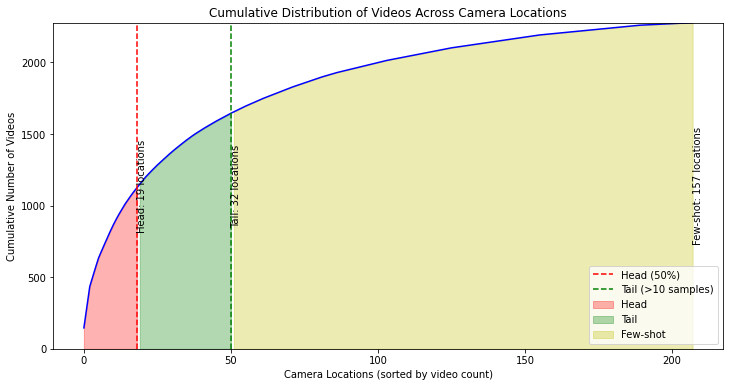

In [33]:
plot_camera_locations_distribution(train_df, head=50, tail=10, use_proportion=False)

In [34]:
# Get the location segments
h_df, t_df, f_df = return_ct_location_segments(train_df, head=50, tail=10)

# Merge with original dataframe
h_df = h_df.merge(train_df, on="utm", how="left")
t_df = t_df.merge(train_df, on="utm", how="left")
f_df = f_df.merge(train_df, on="utm", how="left")

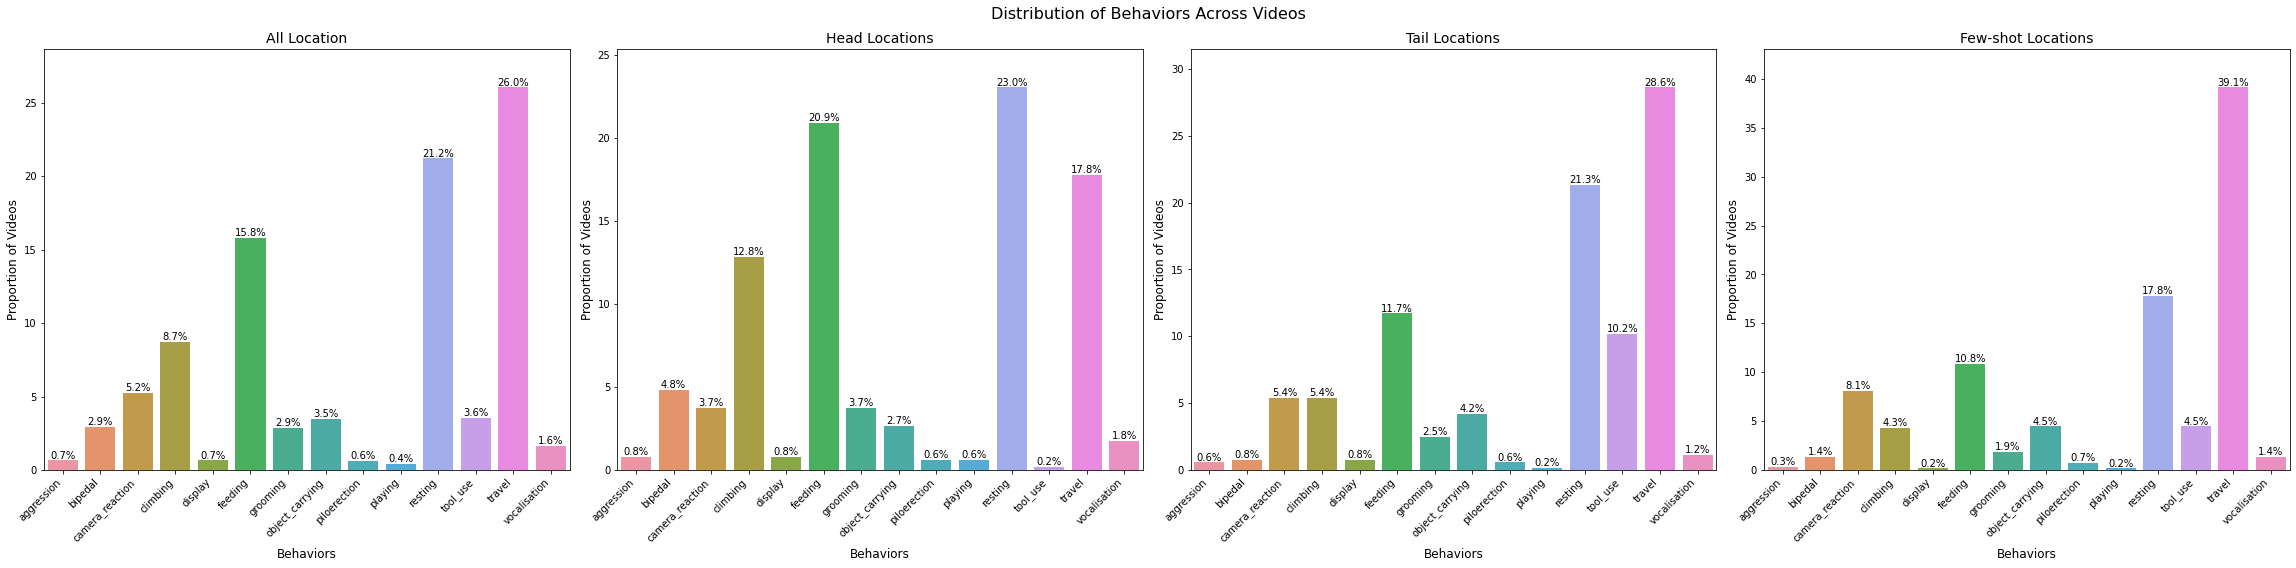

In [35]:
plot_multiple_behavior_distributions(
    [train_df, h_df, t_df, f_df],
    behaviours,
    annot="proportion",
    titles=["All Location", "Head Locations", "Tail Locations", "Few-shot Locations"],
)

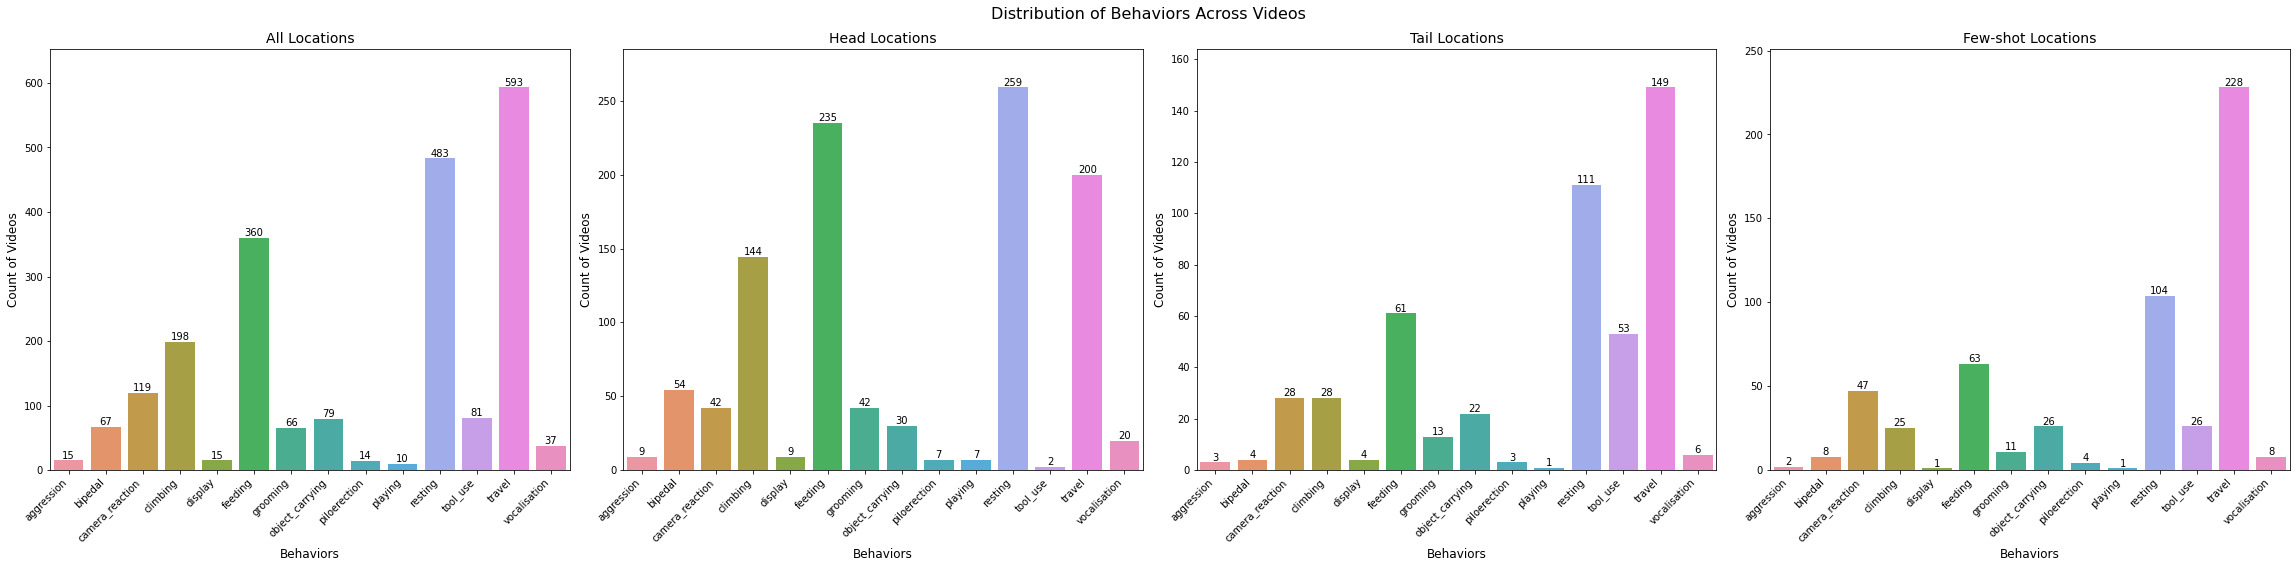

In [36]:
plot_multiple_behavior_distributions(
    [train_df, h_df, t_df, f_df],
    behaviours,
    annot="count",
    titles=["All Locations", "Head Locations", "Tail Locations", "Few-shot Locations"],
)

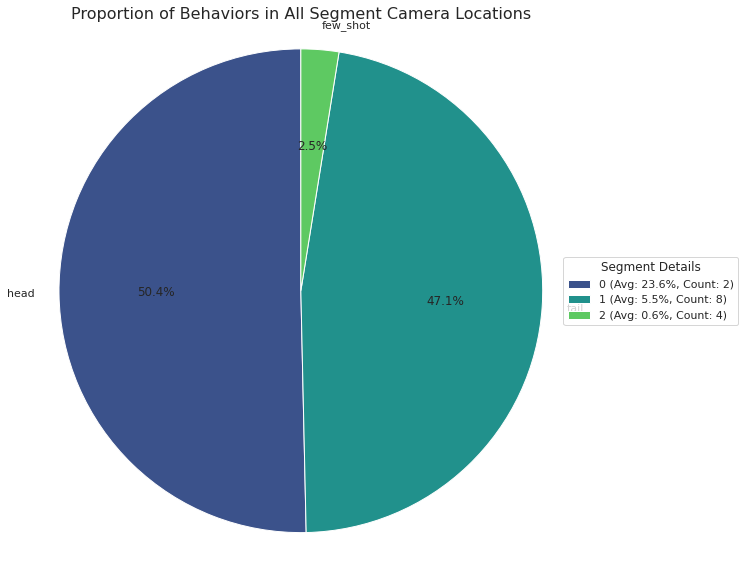

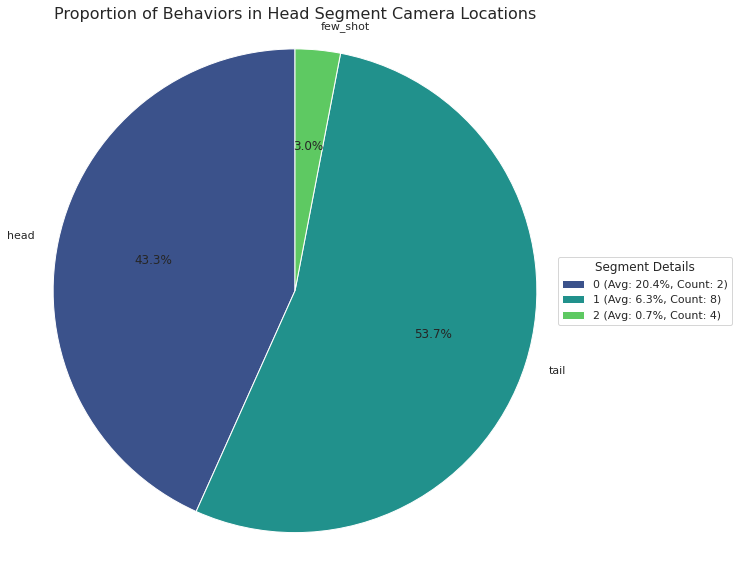

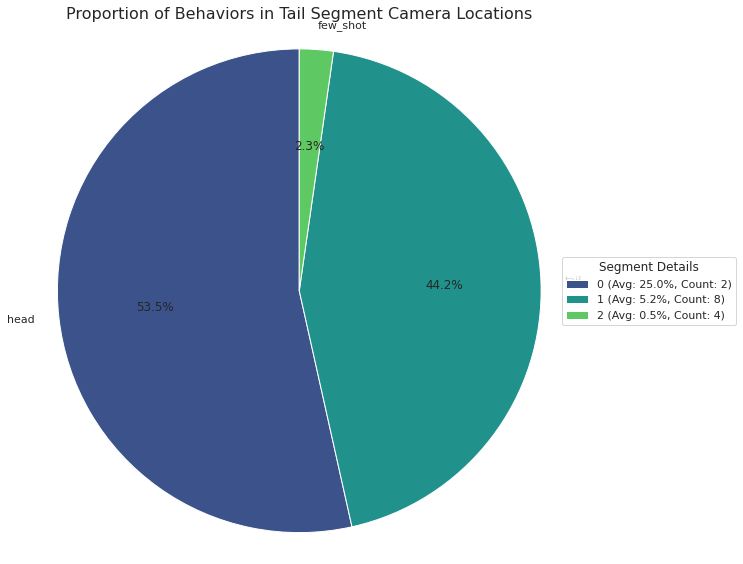

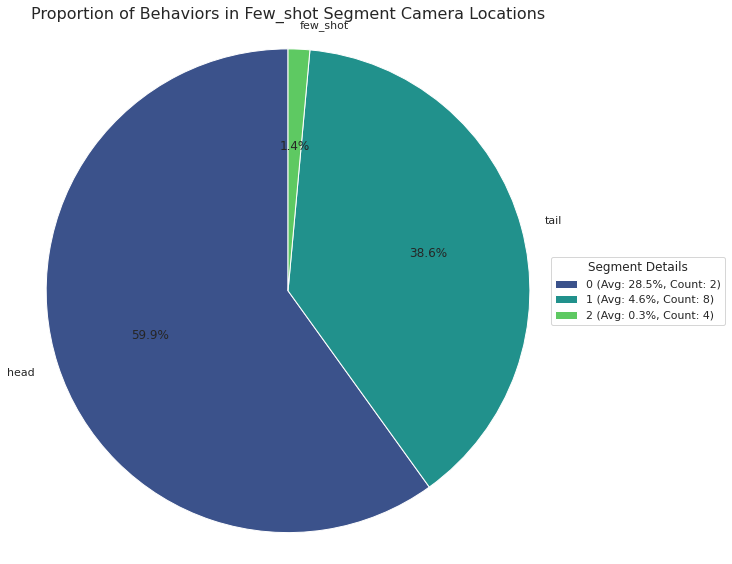

In [37]:
all_df = plot_aggregated_behavior_distribution(
    train_df, behaviours, segments, plot_type="pie"
)

plot_aggregated_behavior_distribution(
    h_df, behaviours, segments, plot_type="pie", segment="head"
)
plot_aggregated_behavior_distribution(
    t_df, behaviours, segments, plot_type="pie", segment="tail"
)
plot_aggregated_behavior_distribution(
    f_df, behaviours, segments, plot_type="pie", segment="few_shot"
)